In [87]:
from scripts._common import *

log = logging.getLogger(__name__)

from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.legend
import numpy as np
import seaborn as sns
from typing import cast

from src.clip_eval import eval_single_dataset
from src.task_vectors import TaskVector

TEST_DATASET = ["SUN397", "Cars", "RESISC45", "EuroSAT", "SVHN", "GTSRB", "MNIST", "DTD"]

sns.set_theme(style="darkgrid")
color_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
# sns.set_palette("bright")

# 设置全局字体为 Times New Roman
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"

In [9]:
labels_data = pd.read_csv("results/clip_dictmoe/ViT-B-32/version_1/samples.csv", header=None, names=["Task", "label"])
# Define the task ID mapping
task_id_mapping = {"SUN397": 0, "Cars": 1, "RESISC45": 2, "EuroSAT": 3, "SVHN": 4, "GTSRB": 5, "MNIST": 6, "DTD": 7}
# Add a new column 'task_id' to the DataFrame
labels_data["task_id"] = labels_data["Task"].map(task_id_mapping)
labels_data

,Task,label,task_id
0,SUN397,0,0
1,SUN397,0,0
2,SUN397,0,0
3,SUN397,0,0
4,SUN397,0,0
...,...,...,...
87428,DTD,46,7
87429,DTD,46,7
87430,DTD,46,7
87431,DTD,46,7


In [18]:
routing_weights_dict = {}
for layer_idx in range(12):
    routing_weights = pd.read_csv(f"results/clip_dictmoe/ViT-B-32/version_1/gate_layer={layer_idx}.csv", header=None)
    routing_weights_dict[layer_idx] = routing_weights

In [31]:
routing_weights_dict[0]

,0,1,2,3,4,5,6,7
0,0.585332,0.675529,-0.192608,-0.547534,-0.118151,0.146547,-0.433342,0.269050
1,0.701227,0.752797,-0.333118,-0.752635,-0.131031,0.316828,-0.563372,0.306652
2,0.719011,0.703721,-0.300460,-0.692476,-0.000878,0.301867,-0.645586,0.286968
3,0.630200,0.742642,-0.198709,-0.427574,-0.107924,0.196730,-0.461543,0.228790
4,0.685440,0.729491,-0.231898,-0.708026,-0.094060,0.187150,-0.531386,0.306755
...,...,...,...,...,...,...,...,...
87428,0.657287,0.740888,-0.182944,-0.548113,-0.268275,0.111200,-0.444955,0.365896
87429,0.673499,0.636591,-0.110666,-0.746359,0.039825,0.193668,-0.524419,0.299363
87430,0.656465,0.714864,-0.042268,-0.455984,-0.176914,0.145653,-0.318018,0.362631
87431,0.723305,0.452834,-0.039363,-1.139602,0.022746,0.170186,-0.640252,0.474043


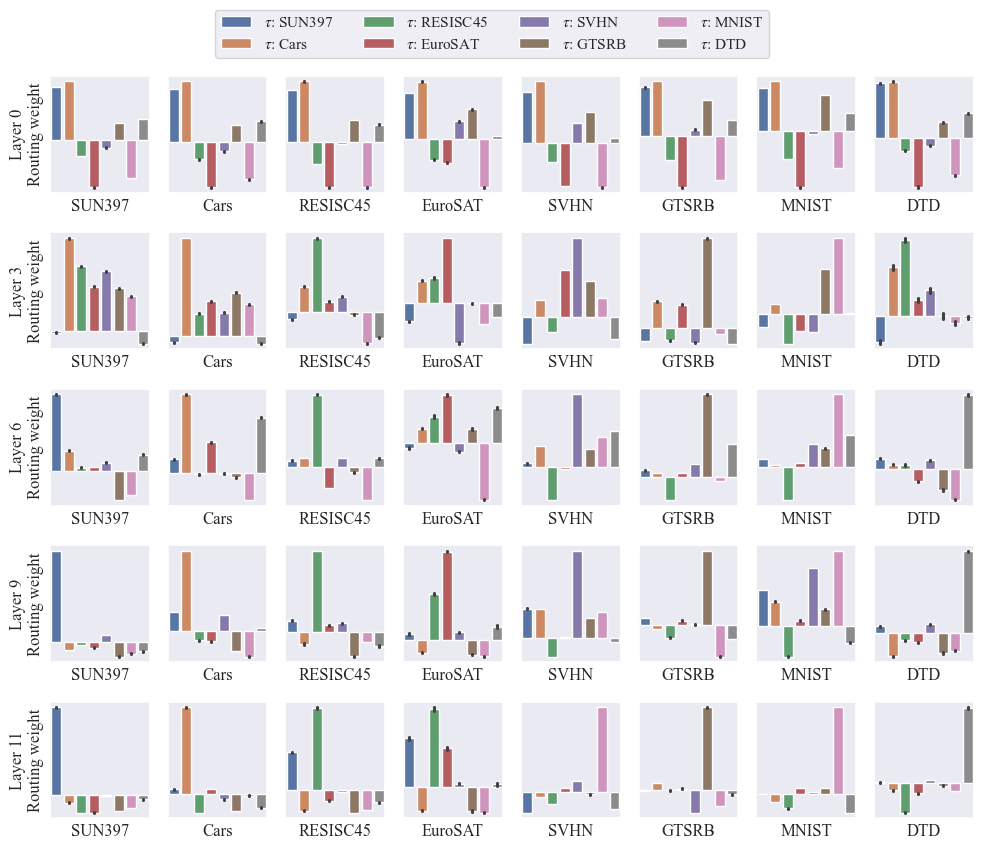

In [54]:
def plot_layer(layer_idx: int, axes: List[plt.Axes]):
    routing_weights = routing_weights_dict[layer_idx]
    # axes[0].set_ylabel(f"Layer {layer_idx}")
    for task_id, task_name in enumerate(TEST_DATASET):
        ax = axes[task_id]
        ax.set_xlabel(task_name)
        sns.barplot(routing_weights[labels_data["task_id"] == task_id], ax=ax, label=task_name)
        if task_id == 0:
            ax.set_ylabel(f"Layer {layer_idx}\nRouting weight")
        ax.set_yticks([])
        ax.set_xticks([])


fig, axes = plt.subplots(5, 8, figsize=(10, 8))

layer_idx = 0
plot_layer(layer_idx, axes[0])

layer_idx = 3
plot_layer(layer_idx, axes[1])

layer_idx = 6
plot_layer(layer_idx, axes[2])

layer_idx = 9
plot_layer(layer_idx, axes[3])

layer_idx = 11
plot_layer(layer_idx, axes[4])

handles, labels = axes[0][0].get_legend_handles_labels()
labels = [rf"$\tau$: {TEST_DATASET[i]}" for i in range(8) if i < len(labels)]
fig.legend(handles, labels, loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.07))

plt.tight_layout()

plt.savefig("routing_analysis.pdf", bbox_inches="tight")
plt.show()

In [73]:
def first_choice_prob(task_id: int, layer_idx: int):
    routing_weights = routing_weights_dict[layer_idx]
    routing_weights = routing_weights[labels_data["task_id"] == task_id]
    routing_weights = np.array(routing_weights)
    prob = (routing_weights.argmax(axis=1) == task_id).sum() / len(routing_weights)
    return prob


first_choice_prob_matrix = np.zeros((len(TEST_DATASET), len(routing_weights_dict)))
for task_id in range(len(TEST_DATASET)):
    for layer_idx in range(len(routing_weights_dict)):
        first_choice_prob_matrix[task_id, layer_idx] = first_choice_prob(task_id, layer_idx)
display(first_choice_prob_matrix)

array([[1.84332494e-01, 1.51133501e-03, 0.00000000e+00, 0.00000000e+00,
        4.50277078e-01, 1.16120907e-01, 9.39798489e-01, 9.32141058e-01,
        9.13954660e-01, 9.84483627e-01, 9.87002519e-01, 9.78992443e-01],
       [9.17174481e-01, 6.35866186e-01, 9.97512747e-01, 9.72267131e-01,
        9.95398582e-01, 9.80972516e-01, 9.23268250e-01, 9.99502549e-01,
        9.98880736e-01, 9.76246735e-01, 9.78485263e-01, 9.83957219e-01],
       [0.00000000e+00, 5.96190476e-01, 2.35238095e-01, 8.93015873e-01,
        8.86031746e-01, 9.76507937e-01, 9.53174603e-01, 9.10158730e-01,
        9.24126984e-01, 9.32222222e-01, 9.08730159e-01, 8.02063492e-01],
       [0.00000000e+00, 3.69259259e-01, 4.84444444e-01, 9.99259259e-01,
        7.73703704e-01, 7.97777778e-01, 4.01851852e-01, 9.37777778e-01,
        8.80370370e-01, 8.31481481e-01, 2.91851852e-01, 2.05185185e-01],
       [2.68899816e-04, 7.55301168e-01, 9.56092502e-01, 8.02627535e-01,
        9.91933006e-01, 9.00276583e-01, 9.90895821e-01, 9.56

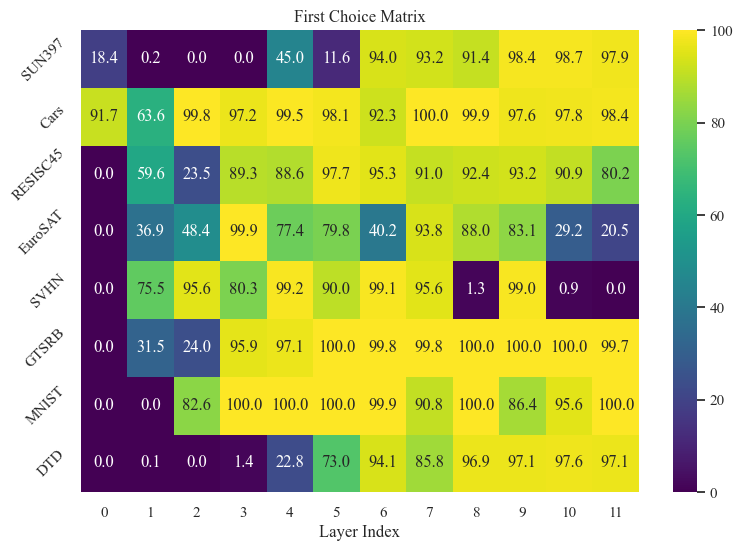

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
ax = cast(plt.Axes, ax)
sns.heatmap(first_choice_prob_matrix * 100, ax=ax, cmap="viridis", annot=True, fmt=".1f")
ax.set_xlabel("Layer Index")
ax.set_yticklabels(TEST_DATASET, rotation=45)
plt.title("First Choice Matrix")
plt.savefig("first_choice_matrix.pdf", bbox_inches="tight")
plt.show()